<h1><b>Import Libraries<b><h1>

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pandas as pd
import pandas_datareader as pdr
import tensorflow
import keras
from keras.preprocessing import sequence
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
import time
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.svm import SVR, SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools

<h1><b>Input Data from Yahoo Finance<b><h1>

In [2]:
import yfinance as yf

ticker = 'HDFCBANK.NS'
start_date = '2022-01-01'
end_date = '2023-11-30'

DF = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [3]:
DF

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,1485.000000,1523.000000,1480.500000,1519.650024,1485.152466,4534592
2022-01-04,1520.000000,1532.900024,1507.800049,1528.550049,1493.850464,4428676
2022-01-05,1536.800049,1572.000000,1528.099976,1564.849976,1529.326416,7166319
2022-01-06,1543.000000,1554.750000,1530.050049,1539.750000,1504.796143,4814465
2022-01-07,1544.000000,1566.750000,1535.900024,1550.550049,1515.351074,5589692
...,...,...,...,...,...,...
2023-11-22,1520.000000,1520.000000,1503.550049,1512.550049,1512.550049,14561825
2023-11-23,1508.500000,1523.849976,1508.500000,1521.300049,1521.300049,6523110
2023-11-24,1521.199951,1533.150024,1519.849976,1532.099976,1532.099976,8234596


<h1><b>Plotting closing price for every day<b><h1>

Text(0, 0.5, 'Value')

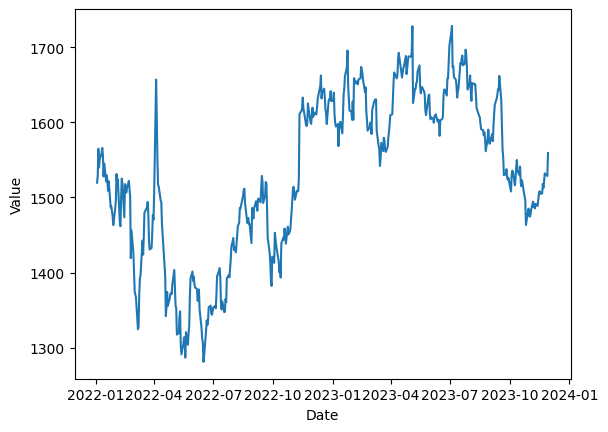

In [4]:
plt.plot(DF.Close)
plt.xlabel('Date')
plt.ylabel('Value')

<h1><b>Define Function<b></h1>

In [5]:
#creating datasets from the dataframe, make data stationary:
def difference_pct_back(datafile, lag = 1):
    diff = [0] * lag
    for i in range(lag,len(datafile)):
        diff.append(datafile[i]/datafile[i-lag]-1)
    return diff

def create_dataset_percentage_gap(dataset, window_size, look_forward, gap): #MinMaxScaler(feature_range=(0, 1))
    i = 0
    data_X, data_Y = [], []
    while i in range(len(dataset) - window_size - look_forward):
        a = dataset[i:(i + window_size), :]
        data_X.append(a)
        b = dataset[i + window_size + look_forward-1, 0]/dataset[i+window_size-1,0]-1
        data_Y.append(b)
        i += gap

    x = np.array(data_X)
    y = np.array(data_Y)
    y = y.reshape(-1,1)
    return (x,y)

def create_dataset_difference_gap(dataset, window_size, look_forward, gap): #MinMaxScaler(feature_range=(0, 1))
    i = 0
    data_X, data_Y = [], []
    while i in range(len(dataset) - window_size - look_forward):
        a = dataset[i:(i + window_size), :]
        data_X.append(a)
        b = dataset[i + window_size + look_forward-1, 0]-dataset[i+window_size-1,0]
        data_Y.append(b)
        i += gap

    x = np.array(data_X)
    y = np.array(data_Y)
    y = y.reshape(-1,1)
    return (x,y)

#regression to classification:
def y_classifier(array, threshold):
    classes = []
    for i in range(len(array)):
        if array[i,0] > threshold:
            classes.append(1)
        elif array[i,0] < -1*threshold:
            classes.append(-1)
        else:
            classes.append(0)
    return np.asarray(classes)

#defining moving averages:
def EMA(df, EMA_days):
    sma = np.mean(df[0:EMA_days])
    EMA_list = [0] * (EMA_days - 1)
    EMA_list.append(sma)
    c = 2/(1+EMA_days)
    for i in range(EMA_days,len(df)):
        a = EMA_list[i-1]*(1-c)+ c*df[i]
        EMA_list.append(a)
    return(EMA_list)

def SMA(df, sma_days):
    sma_list = [0] * (sma_days - 1)
    for i in range(sma_days, len(df)+1):
        sma_list.append(np.mean(df[i-sma_days:i]))
    return(sma_list)

#defining some metrics
def rms(y, pred):
    temp = 0
    if len(y) != len(pred):
        return False
    else:
        for i in range(len(y)):
            temp += (y[i][0] - pred[i][0])**2
        return temp/len(y)

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)+0.0000000001))

def mae(A, F):
    return 1/len(A) * np.sum(np.abs(F - A))

#autocorrelation benchmark:
def benchmark(y, look_forward):
    Y_hat = []
    Y_real = []
    for i in range(2*look_forward, len(y)):
        a = np.mean(y[i-2*look_forward:i-look_forward,0])
        Y_hat.append(a)
        Y_real.append(y[i,0])
    return (np.asarray(Y_real), np.asarray(Y_hat))

def pretty_print_conf_matrix(y_true, y_pred, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(),2)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

def plot(y_train, prediction_train,y_test, prediction_test):
    fig = plt.figure()
    plt.rcParams.update({'font.size': 18})
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    plt.scatter(y_train, prediction_train)
    plt.ylabel('predicted')
    plt.xlabel('actual')
    plt.title('ML-Train')


    plt.subplot(1, 2, 2)
    plt.scatter(y_test, prediction_test)
    plt.ylabel('predicted')
    plt.xlabel('actual')
    plt.title('ML-Test')
    plt.show()

    plt.figure(figsize=(15,8))
    plt.subplot(2, 1, 1)
    plt.plot(prediction_train, marker = '*',linestyle="None", label = 'Pred')
    plt.plot(y_train, marker = '.', label = 'Y', linestyle="None")
    plt.grid()
    plt.legend()
    plt.title('Train')
    plt.subplots_adjust(hspace = 0.4)

    plt.subplot(2, 1, 2)
    plt.plot(prediction_test, marker = '*', label = 'Pred',linestyle="None")
    plt.plot(y_test, marker = '.',linestyle="None" , label = 'Y')
    plt.grid()
    plt.legend()
    plt.title('Test')

#this function changes 1D y array to an array with 3 features that is used for softmax
def y_softmax(array):
    lst = []
    for i in range(len(array)):
        if array[i] == 1:
            lst.append([1,0,0])
        elif array[i] == 0:
            lst.append([0,1,0])
        else:
            lst.append([0,0,1])
    return np.asarray(lst)


def softmaxifier(array):
    zeros = [0, 0, 0]
    pred = []
    for i in range(len(array)):
        j = np.argmax(array[i])
        temp = [0,0,0]
        temp[j] = 1
        pred.append(temp)
    return pred

#this function changes 3D y array with 3 features that was generated by softmax to an 1D array for confusion matrix
def desoftmaxer(array):
    lst = []
    for i in range(len(array)):
        if np.argmax(array[i]) == 0:
            lst.append(1)
        elif np.argmax(array[i]) == 1:
            lst.append(0)
        else:
            lst.append(-1)
    return (np.asarray(lst))
#fix random effect
def fix_rnd_Keras():
    seed_value= 0
    import os
    os.environ['PYTHONHASHSEED']=str(seed_value)
    import random
    random.seed(seed_value)
    import numpy as np
    np.random.seed(seed_value)
    import tensorflow as tf
    tf.set_random_seed(seed_value)
    from keras import backend as K
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)

#split x and y to test and train that are devisible to batch_size
def test_train_split(x, y, batch_size, train_ratio):
    train_length = int(len(x)*train_ratio)
    for i in range(train_length, train_length+batch_size):
        remainder = i%batch_size
        if remainder == 0:
            train_length = i
            break
    x_train = x[:train_length,:]
    y_train = y[:train_length]

    for i in range(len(x)-batch_size, len(x)):
        remainder = i%batch_size
        if remainder == 0:
            train_length_test = i
            break
    x_test = x[train_length:train_length_test,:]
    y_test = y[train_length:train_length_test]
    return x_train, y_train, x_test, y_test

<h1><b>Creating Features<b></h1>

In [6]:
df = DF.Close
df = df.dropna(axis=0, how='any')

#making moving averages
v_10 = SMA(DF.Volume, 10)
v_20 = SMA(DF.Volume, 20)
open_close = (DF.Close/DF.Open - 1).tolist()
high_low = (DF.High/DF.Low - 1).tolist()
EMA_8 = EMA(df,8)
SMA_10 = SMA(df,10)
SMA_20 = SMA(df,20)
SMA_50 = SMA(df,50)
SMA_100 = SMA(df,100)
pct_day = difference_pct_back(df, 1)
list_df = df.tolist()
vol_list = DF.Volume.tolist()
MAs = pd.DataFrame(list(zip(list_df, pct_day, vol_list, v_10, v_20,open_close,high_low, EMA_8, SMA_10,
                            SMA_20, SMA_50, SMA_100)),columns=['spot', 'pct_day', 'vol', 'v_10', 'v_20',
                            'open_close', 'high_low', 'EMA_8', 'SMA_10', 'SMA_20', 'SMA_50','SMA_100'])

#removing all rows with 0 in them
MAs = MAs[100:]
MAs = MAs.reset_index(drop=True)

#making differences as features
MAs['v10'] = MAs.vol/MAs.v_10 - 1
MAs['v20'] = MAs.vol/MAs.v_20 - 1
MAs['spot_EMA'] = MAs.spot/MAs.EMA_8 - 1
MAs['spot_20SMA'] = MAs.spot/MAs.SMA_20 - 1
MAs['spot_50SMA'] = MAs.spot/MAs.SMA_50 - 1
MAs['spot_100SMA'] = MAs.spot/MAs.SMA_100 - 1
MAs['10_100_SMA'] = MAs.SMA_10/MAs.SMA_100 - 1
MAs['20_50_SMA'] = MAs.SMA_20/MAs.SMA_50 - 1
MAs = MAs.drop(['EMA_8', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_100', 'v_10', 'v_20'], 1)

C:\Users\soham\AppData\Local\Temp\ipykernel_21488\1380255108.py:34: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  MAs = MAs.drop(['EMA_8', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_100', 'v_10', 'v_20'], 1)


<h1><b>Visualisation<b></h1>

,spot,pct_day,vol,open_close,high_low,v10,v20,spot_EMA,spot_20SMA,spot_50SMA,spot_100SMA,10_100_SMA,20_50_SMA
0,1388.949951,-0.008990,6742694,-0.004979,0.017971,-0.218545,-0.293576,0.019137,0.041487,-0.010968,-0.037423,-0.069760,-0.050365
1,1394.849976,0.004248,6045948,0.010761,0.015444,-0.284195,-0.337120,0.018157,0.044389,-0.005560,-0.032438,-0.063282,-0.047827
2,1385.099976,-0.006990,5737510,-0.001550,0.006819,-0.282204,-0.359727,0.008565,0.035842,-0.011082,-0.038001,-0.055302,-0.045300
3,1380.300049,-0.003465,3478622,-0.012873,0.017765,-0.544988,-0.589140,0.003939,0.029838,-0.012904,-0.040272,-0.050128,-0.041504
4,1378.449951,-0.001340,3086633,0.001562,0.019366,-0.557756,-0.604377,0.002016,0.026215,-0.012804,-0.040410,-0.043808,-0.038022


<Figure size 640x480 with 0 Axes>

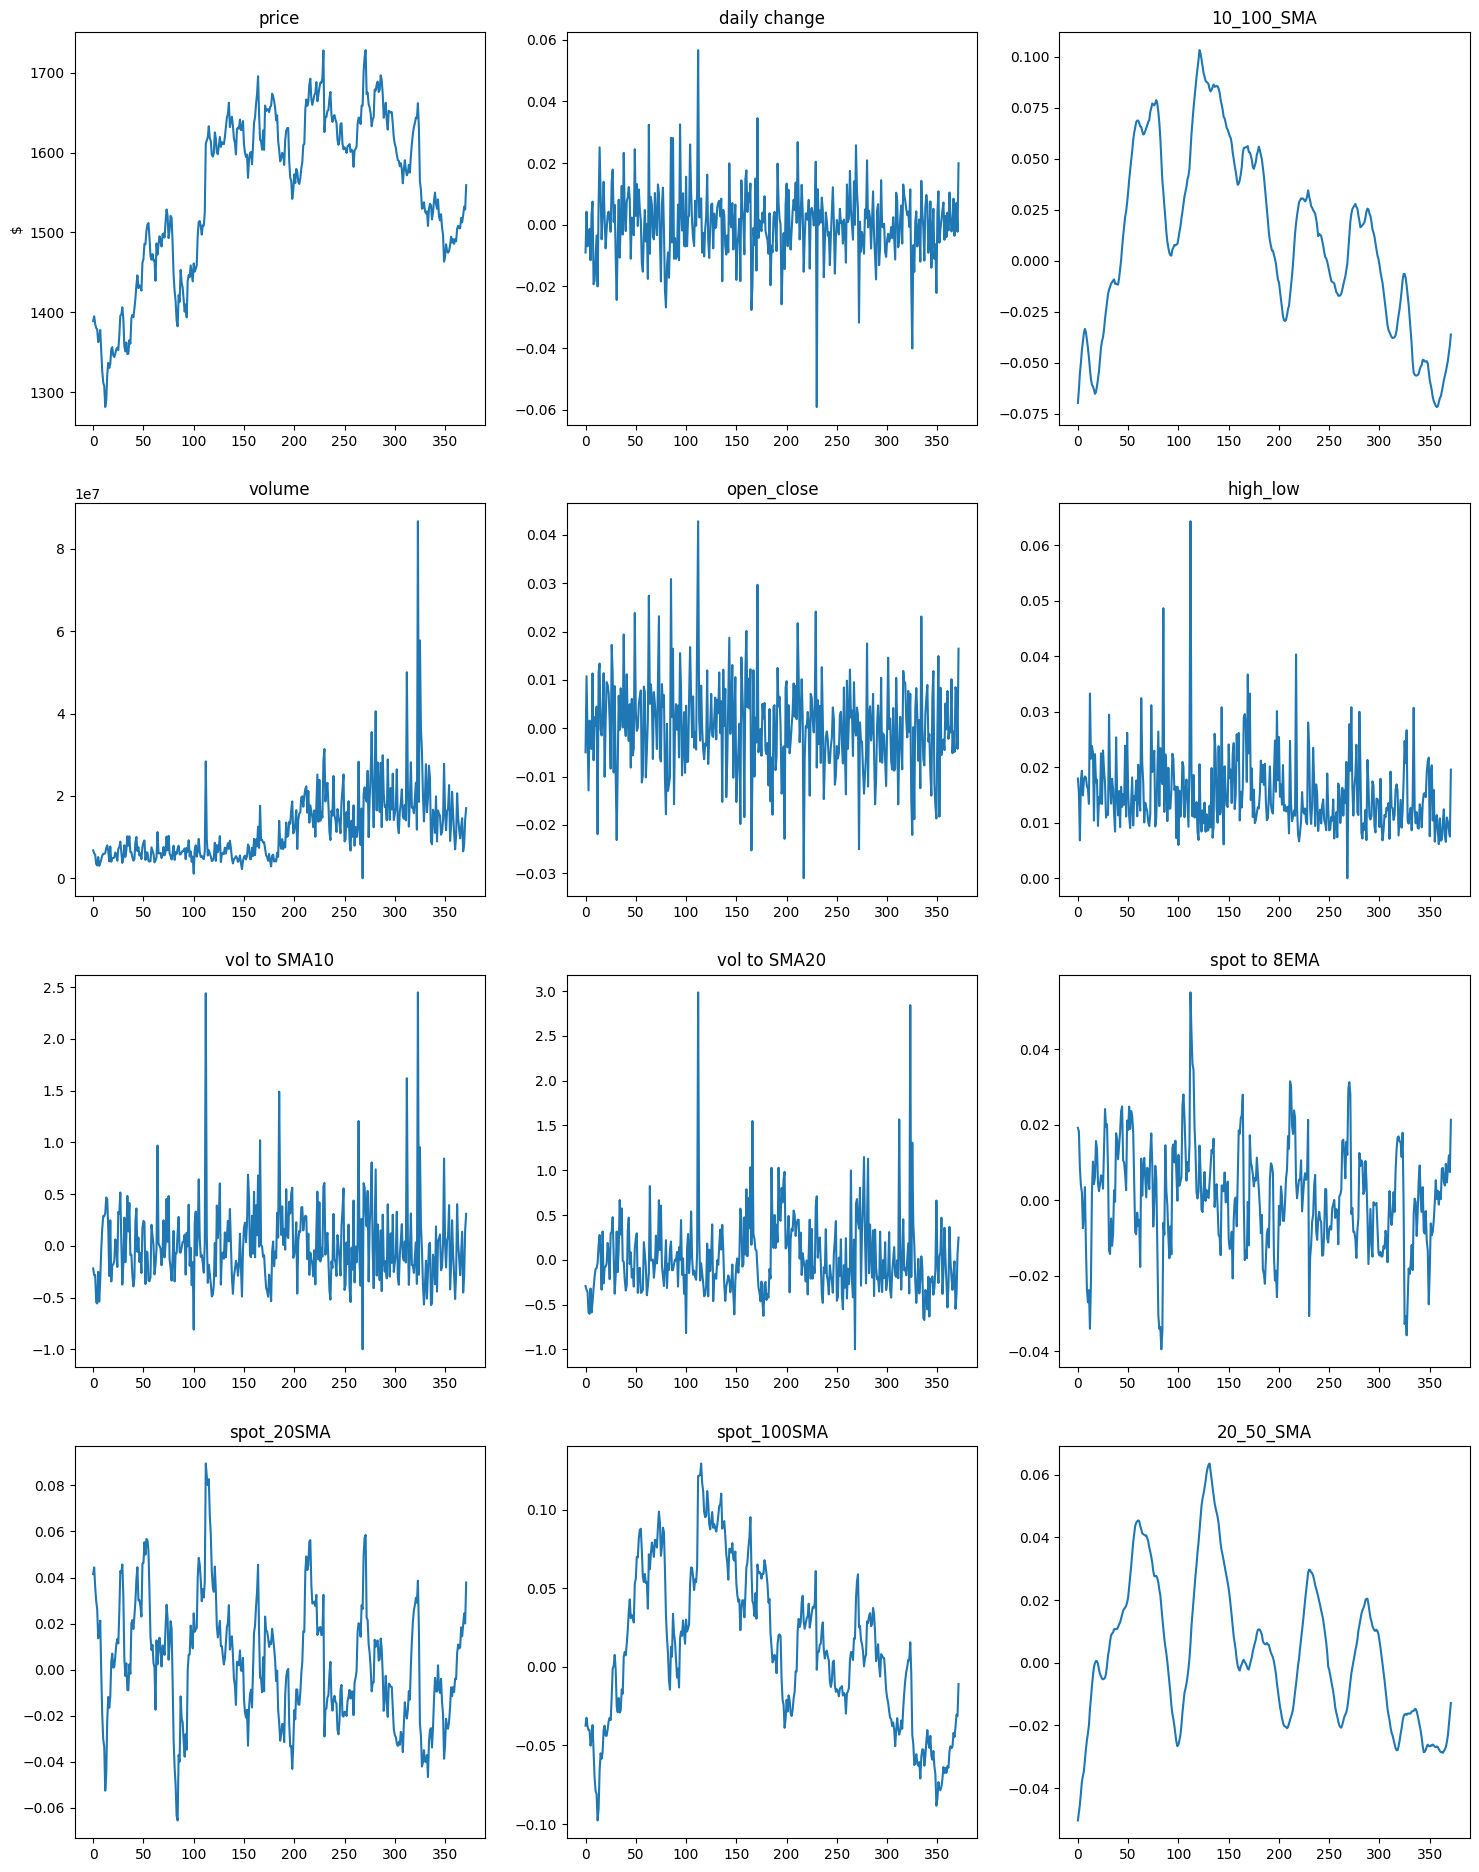

In [7]:
fig = plt.figure()
plt.figure(figsize=(18,14))

plt.subplot(4, 3, 1)
plt.plot(MAs.spot)
plt.ylabel('$')
plt.title('price')

plt.subplot(4, 3, 2)
plt.plot(MAs.pct_day)
plt.title('daily change')

plt.subplot(4, 3, 3)
plt.plot(MAs['10_100_SMA'])
plt.title('10_100_SMA')

plt.subplot(4, 3, 4)
plt.plot(MAs.vol)
plt.title('volume')
plt.subplots_adjust(top = 1.4)

plt.subplot(4, 3, 5)
plt.plot(MAs.open_close)
plt.title('open_close')

plt.subplot(4, 3, 6)
plt.plot(MAs.high_low)
plt.title('high_low')

plt.subplot(4, 3, 7)
plt.plot(MAs.v10)
plt.title('vol to SMA10')

plt.subplot(4, 3, 8)
plt.plot(MAs.v20)
plt.title('vol to SMA20')

plt.subplot(4, 3, 9)
plt.plot(MAs.spot_EMA)
plt.title('spot to 8EMA')

plt.subplot(4, 3, 10)
plt.plot(MAs.spot_20SMA)
plt.title('spot_20SMA')

plt.subplot(4, 3, 11)
plt.plot(MAs.spot_100SMA)
plt.title('spot_100SMA')

plt.subplot(4, 3, 12)
plt.plot(MAs['20_50_SMA'])
plt.title('20_50_SMA')
MAs.head(5)

<h1><b>Opening Price Prediction<b><h1>

In [8]:
import math
import numpy as np
import pandas as pd
import pandas_datareader as web
#from sklearn.tree import DecisionTreeRegressor
#from sklearn.linear_model import LinearRegression
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

In [9]:
import yfinance as yf
import datetime

ticker = 'HDFCBANK.NS'
start_date = datetime.datetime(2022, 1, 1)
end_date = datetime.datetime(2023, 11, 30)

df = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [10]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,1485.000000,1523.000000,1480.500000,1519.650024,1485.152466,4534592
2022-01-04,1520.000000,1532.900024,1507.800049,1528.550049,1493.850464,4428676
2022-01-05,1536.800049,1572.000000,1528.099976,1564.849976,1529.326416,7166319
2022-01-06,1543.000000,1554.750000,1530.050049,1539.750000,1504.796143,4814465
2022-01-07,1544.000000,1566.750000,1535.900024,1550.550049,1515.351074,5589692
...,...,...,...,...,...,...
2023-11-22,1520.000000,1520.000000,1503.550049,1512.550049,1512.550049,14561825
2023-11-23,1508.500000,1523.849976,1508.500000,1521.300049,1521.300049,6523110
2023-11-24,1521.199951,1533.150024,1519.849976,1532.099976,1532.099976,8234596


In [11]:
df.shape

(472, 6)

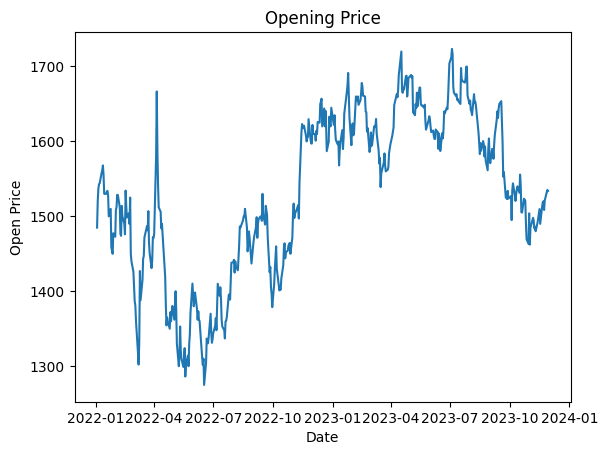

In [12]:
plt.figure()
plt.title('Opening Price')
plt.plot(df['Open'])
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.show()

In [13]:
data=df.filter(['Open'])

#Convert to np array
dataset=data.values

#Get the number of rows to train the model on
#math.ceil to round up

training_data_len = math.ceil(len(dataset)*.8)

#print(dataset)
training_data_len

378

In [14]:
#Scale the data

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [15]:
#Create training dataset
#Create scaled training dataset

train_data = scaled_data[0:training_data_len,:]

#Split the data into x_train and y_train data set

x_train=[]
y_train=[]

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()

[array([0.46827968, 0.54632629, 0.58378878, 0.59761407, 0.59984397,
       0.63106262, 0.63897888, 0.65336165, 0.62437291, 0.56862533,
       0.56862533, 0.57531504, 0.57754494, 0.56516887, 0.50172823,
       0.52391566, 0.40952178, 0.39023307, 0.45155541, 0.44096337,
       0.52068241, 0.52837546, 0.56583795, 0.56505754, 0.52871   ,
       0.44910257, 0.44375075, 0.53294687, 0.50228571, 0.4794292 ,
       0.44821055, 0.57832535, 0.53093991, 0.4979375 , 0.51064784,
       0.47898333, 0.55769875, 0.39001013, 0.36782243, 0.33671539,
       0.24863421, 0.23636974, 0.18954178, 0.09700079, 0.06065326,
       0.12264468, 0.33894529, 0.25197907, 0.31218645, 0.3757387 ,
       0.38354336, 0.43929094, 0.47273949, 0.46002915, 0.51733755,
       0.42591152, 0.39246297, 0.34764197, 0.37016394, 0.43929094])]
[0.437061035435101]



In [16]:
#convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [17]:
#Reshape the data into 3 dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(318, 60, 1)

<h1><b>Model Training<b></h1>

In [18]:
#Build LSTM model
model=Sequential()
#Add first layer to model
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
#Add second layer to model
model.add(LSTM(50, return_sequences=False))
#Add Dense Layer to model with 25 neurons
model.add(Dense(25))
#Add Dense Layer to model with 1 neuron
model.add(Dense(1))

In [19]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [20]:
#Train the model
model.fit(x_train, y_train, batch_size=1,epochs=25)

Epoch 1/25
318/318 [==============================] - 9s 18ms/step - loss: 0.0165
Epoch 2/25
318/318 [==============================] - 6s 18ms/step - loss: 0.0078
Epoch 3/25
318/318 [==============================] - 5s 17ms/step - loss: 0.0072
Epoch 4/25
318/318 [==============================] - 5s 17ms/step - loss: 0.0055
Epoch 5/25
318/318 [==============================] - 5s 17ms/step - loss: 0.0047
Epoch 6/25
318/318 [==============================] - 5s 17ms/step - loss: 0.0040
Epoch 7/25
318/318 [==============================] - 5s 17ms/step - loss: 0.0037
Epoch 8/25
318/318 [==============================] - 5s 17ms/step - loss: 0.0039
Epoch 9/25
318/318 [==============================] - 6s 17ms/step - loss: 0.0032
Epoch 10/25
318/318 [==============================] - 6s 17ms/step - loss: 0.0032
Epoch 11/25
318/318 [==============================] - 6s 17ms/step - loss: 0.0036
Epoch 12/25
318/318 [==============================] - 6s 18ms/step - loss: 0.0033
Epoch 13/25
3

<h1><b>Testing and Validating Model<b><h1>

In [21]:
#Create the test data set
#Create a new array containing scaled values

test_data=scaled_data[training_data_len-60: , : ]
#Create the data sets x_test and y_test

x_test=[]
y_test=dataset[training_data_len:,:]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [22]:
#Convert the data to a numpy array

x_test=np.array(x_test)

In [23]:
#Reshape the data to 3d
x_test=np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1))

In [24]:
#Get the models predicted price values

predictions=model.predict(x_test)
predictions=scaler.inverse_transform(predictions)

3/3 [==============================] - 2s 24ms/step


In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse =np.sqrt(np.mean(predictions-y_test)**2)



print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
mape = mean_absolute_percentage_error(y_test, predictions)
print("Mean Absolute Percentage Error (MAPE):", mape)


Mean Squared Error: 370.6935858346046
Mean Absolute Error: 14.849063954454786
Root Mean Squared Error: 4.982564723238032
Mean Absolute Percentage Error (MAPE): 0.9515498926575817


C:\Users\soham\AppData\Local\Temp\ipykernel_21488\3856801789.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = predictions


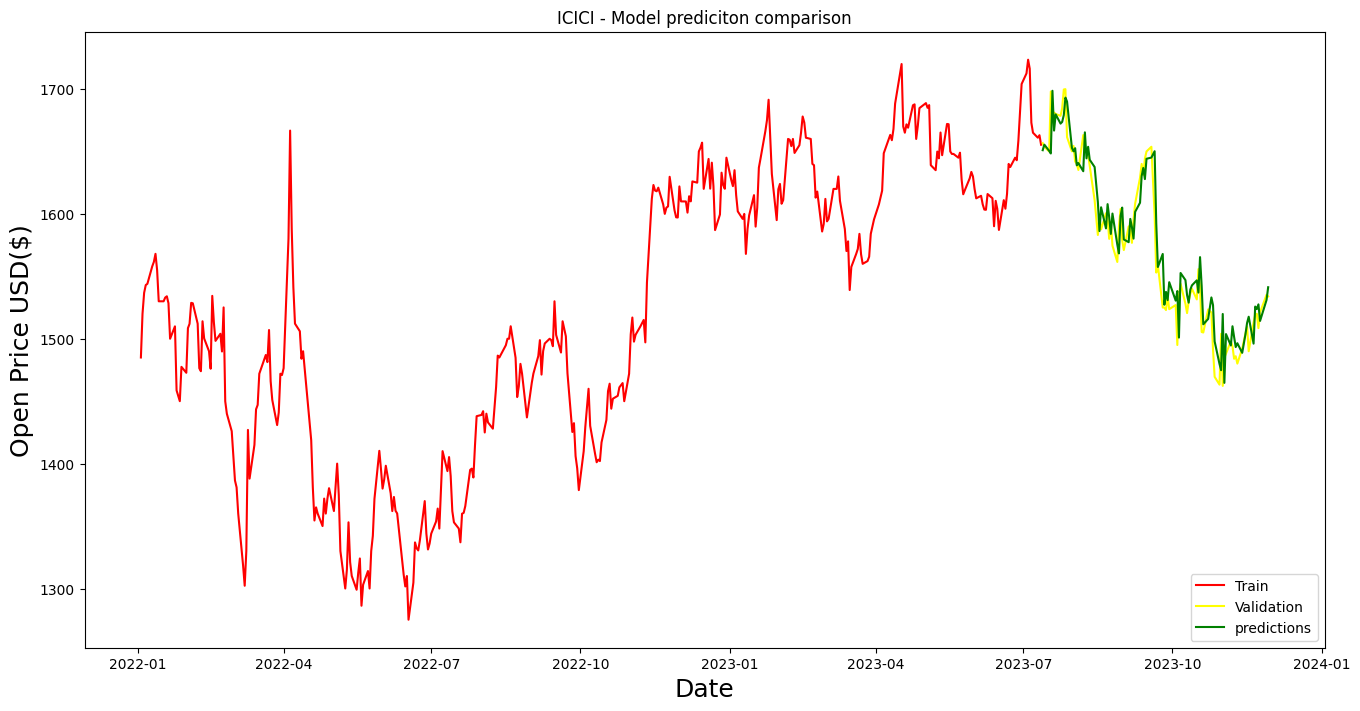

In [26]:
#plot the data

train=data[:training_data_len]
valid=data[training_data_len:]
valid['predictions'] = predictions

#Visualize the data
plt.figure(figsize=(16,8))
plt.title('ICICI - Model prediciton comparison')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD($)', fontsize=18)
plt.plot(train['Open'] , color='red')
plt.plot(valid['Open'] , color='yellow')
plt.plot(valid[ 'predictions'] , color='green')
plt.legend(['Train','Validation', 'predictions'], loc='lower right')
plt.show()

In [27]:
#Show the valid and predicted prices

valid.tail(30)

,Open,predictions
Date,,
2023-10-16,1531.500000,1546.791748
2023-10-17,1555.750000,1536.972900
2023-10-18,1541.199951,1565.373291
2023-10-19,1505.400024,1542.363159
2023-10-20,1505.000000,1511.578369
2023-10-23,1523.500000,1515.860474
2023-10-25,1521.000000,1533.096680
2023-10-26,1491.250000,1526.923462
2023-10-27,1469.500000,1497.861328


<h1><b>Getting Predictions for Tomorrow<b></h1>

In [28]:
#Get the quote
ticker = 'HDFCBANK.NS'
start_date = '2022-01-01'
end_date = '2023-11-30'
stock_quote = yf.download(ticker, start=start_date, end=end_date)

new_df=stock_quote.filter(['Open'])
#Get last 60 days values and convert into array
last_60_days=new_df[-60:].values

#Scale the data to be values between 0
last_60_days_scaled=scaler.transform(last_60_days)

#Create an empty list
X_test=[]
#Appemd the past 60days
X_test.append(last_60_days_scaled)

#Conver the X_test data into numpy array
X_test = np.array(X_test)

#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
#Get predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling
pred_price=scaler.inverse_transform(pred_price)
print(f'Opening Price of {ticker} tomorrow:{pred_price}')

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 15ms/step
Opening Price of HDFCBANK.NS tomorrow:[[1538.817]]


<h1><b>Getting Predictions for 60 days from now<b></h1>

In [30]:
import yfinance as yf
import numpy as np

# Assuming you already have the 'model' and 'scaler' objects defined

# Get historical stock data
ticker = 'HDFCBANK.NS'
start_date = '2022-01-01'
end_date = '2023-11-30'
stock_quote = yf.download(ticker, start=start_date, end=end_date)

# Extract 'Open' prices
new_df = stock_quote.filter(['Open'])

# Take the last 60 days of 'Open' prices and scale them
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)

# Create an empty list to store predicted prices
predicted_prices = []

# Number of days to forecast (adjust as needed)
forecast_days = 60

# Loop through the forecast period
for _ in range(forecast_days):
    # Reshape the data for prediction
    X_test = np.array([last_60_days_scaled])
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Get predicted scaled price
    pred_price = model.predict(X_test)

    # Undo the scaling
    pred_price = scaler.inverse_transform(pred_price)

    # Append the predicted price to the list
    predicted_prices.append(pred_price[0, 0])

    # Update last_60_days for the next iteration
    last_60_days = np.append(last_60_days[1:], pred_price, axis=0)
    last_60_days_scaled = scaler.transform(last_60_days)

# Print the predicted prices for the next 2 months
for i, price in enumerate(predicted_prices, 1):
    print(f'Day {i}: Predicted Opening Price of {ticker}: {price}')


[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 25ms/step
Day 1: Predicted Opening Price of HDFCBANK.NS: 1538.8170166015625
Day 2: Predicted Opening Price of HDFCBANK.NS: 1545.4449462890625
Day 3: Predicted Opening Price of HDFCBANK.NS: 1550.78369140625
Day 4: Predicted Opening Price of HDFCBANK.NS: 1555.73876953125
Day 5: Predicted Opening Price of HDFCBANK.NS: 1560.2974853515625
Day 6: Predicted Opening Price of HDFCBANK.NS: 1564.4954833984375
Day 7: Predicted Opening Price of HDFCBANK.NS: 1568.3707275390625
Day 8: Predicted Opening Price of HDFCBANK.NS: 1571.9598388671875
Day 9: Predicted Opening Price of HDFCBANK.NS: 1575.2965087890625
Day 10: Predicted Opening Price of HDFCBANK.NS: 1578.4097900390625
Day 11: Predicted Opening Price of HDFCBANK.NS: 1581.3236083984375
Day 12: Predicted Opening Price of HDFCBANK.NS: 1584.0574951171875
Day 13: Predicted Opening Price of HDFCBANK.NS: 1586.626953125
Day 14: Predicted Opening

<h1><b>Closing Price Prediction<b></h1>

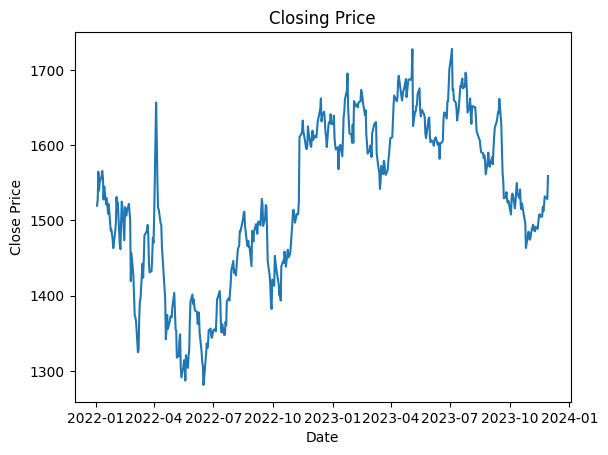

In [31]:
plt.figure()
plt.title('Closing Price')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [32]:
data=df.filter(['Close'])

#Convert to np array
dataset=data.values

#Get the number of rows to train the model on
#math.ceil to round up

training_data_len = math.ceil(len(dataset)*.8)


#print(dataset)
training_data_len

378

In [33]:
#Scale the data

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.53334085],
       [0.55325588],
       [0.63448196],
       [0.57831731],
       [0.60248391],
       [0.62172754],
       [0.63683159],
       [0.61613344],
       [0.55202507],
       [0.59040061],
       [0.53748043],
       [0.55482212],
       [0.53065553],
       [0.50950996],
       [0.53770414],
       [0.45949882],
       [0.46263156],
       [0.43331829],
       [0.40713804],
       [0.4573729 ],
       [0.48265831],
       [0.5591854 ],
       [0.5237189 ],
       [0.54307452],
       [0.41810252],
       [0.40400529],
       [0.48400084],
       [0.54553587],
       [0.53155063],
       [0.43052124],
       [0.52920128],
       [0.52461401],
       [0.50391587],
       [0.51700599],
       [0.53882296],
       [0.51331383],
       [0.49138515],
       [0.30901769],
       [0.39113888],
       [0.32434545],
       [0.2079883 ],
       [0.20071598],
       [0.19064661],
       [0.09733723],
       [0.10405015],
       [0.20105168],
       [0.2492726 ],
       [0.258

In [34]:
#Create training dataset
#Create scaled training dataset

train_data = scaled_data[0:training_data_len,:]

#Split the data into x_train and y_train data set

x_train=[]
y_train=[]

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()

[array([0.53334085, 0.55325588, 0.63448196, 0.57831731, 0.60248391,
       0.62172754, 0.63683159, 0.61613344, 0.55202507, 0.59040061,
       0.53748043, 0.55482212, 0.53065553, 0.50950996, 0.53770414,
       0.45949882, 0.46263156, 0.43331829, 0.40713804, 0.4573729 ,
       0.48265831, 0.5591854 , 0.5237189 , 0.54307452, 0.41810252,
       0.40400529, 0.48400084, 0.54553587, 0.53155063, 0.43052124,
       0.52920128, 0.52461401, 0.50391587, 0.51700599, 0.53882296,
       0.51331383, 0.49138515, 0.30901769, 0.39113888, 0.32434545,
       0.2079883 , 0.20071598, 0.19064661, 0.09733723, 0.10405015,
       0.20105168, 0.2492726 , 0.25844714, 0.36081905, 0.31931077,
       0.37334977, 0.44473046, 0.45916311, 0.4762811 , 0.44294024,
       0.36104276, 0.33475052, 0.33900209, 0.3815172 , 0.43779357])]
[0.4230252138484416]



In [35]:
#convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [36]:
#Reshape the data into 3 dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(318, 60, 1)

<h1><b>Model Training<b></h1>

In [37]:
#Build LSTM model
model=Sequential()
#Add first layer to model
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
#Add second layer to model
model.add(LSTM(50, return_sequences=False))
#Add Dense Layer to model with 25 neurons
model.add(Dense(25))
#Add Dense Layer to model with 1 neuron
model.add(Dense(1))

In [38]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [39]:
#Train the model
model.fit(x_train, y_train, batch_size=1,epochs=50)

Epoch 1/50
318/318 [==============================] - 10s 21ms/step - loss: 0.0151
Epoch 2/50
318/318 [==============================] - 8s 25ms/step - loss: 0.0087
Epoch 3/50
318/318 [==============================] - 9s 28ms/step - loss: 0.0066
Epoch 4/50
318/318 [==============================] - 7s 23ms/step - loss: 0.0057
Epoch 5/50
318/318 [==============================] - 6s 19ms/step - loss: 0.0042
Epoch 6/50
318/318 [==============================] - 5s 17ms/step - loss: 0.0039
Epoch 7/50
318/318 [==============================] - 5s 17ms/step - loss: 0.0037
Epoch 8/50
318/318 [==============================] - 6s 17ms/step - loss: 0.0035
Epoch 9/50
318/318 [==============================] - 5s 17ms/step - loss: 0.0033
Epoch 10/50
318/318 [==============================] - 5s 17ms/step - loss: 0.0037
Epoch 11/50
318/318 [==============================] - 5s 17ms/step - loss: 0.0038
Epoch 12/50
318/318 [==============================] - 5s 17ms/step - loss: 0.0031
Epoch 13/50


<h1><b>Testing and Validating Model<b></h1>

In [40]:
#Create the test data set
#Create a new array containing scaled values

test_data=scaled_data[training_data_len-60: , : ]
#Create the data sets x_test and y_test

x_test=[]
y_test=dataset[training_data_len:,:]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [41]:
#Convert the data to a numpy array

x_test=np.array(x_test)

In [42]:
#Reshape the data to 3d
x_test=np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1))

In [43]:
#Get the models predicted price values

predictions=model.predict(x_test)
predictions=scaler.inverse_transform(predictions)


3/3 [==============================] - 1s 21ms/step


In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse =np.sqrt(np.mean(predictions-y_test)**2)



print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
mape = mean_absolute_percentage_error(y_test, predictions)
print("Mean Absolute Percentage Error (MAPE):", mape)


Mean Squared Error: 306.37040049741245
Mean Absolute Error: 13.33929443359375
Root Mean Squared Error: 9.585149237450134
Mean Absolute Percentage Error (MAPE): 0.8546191344997986


C:\Users\soham\AppData\Local\Temp\ipykernel_21488\3539927776.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = predictions


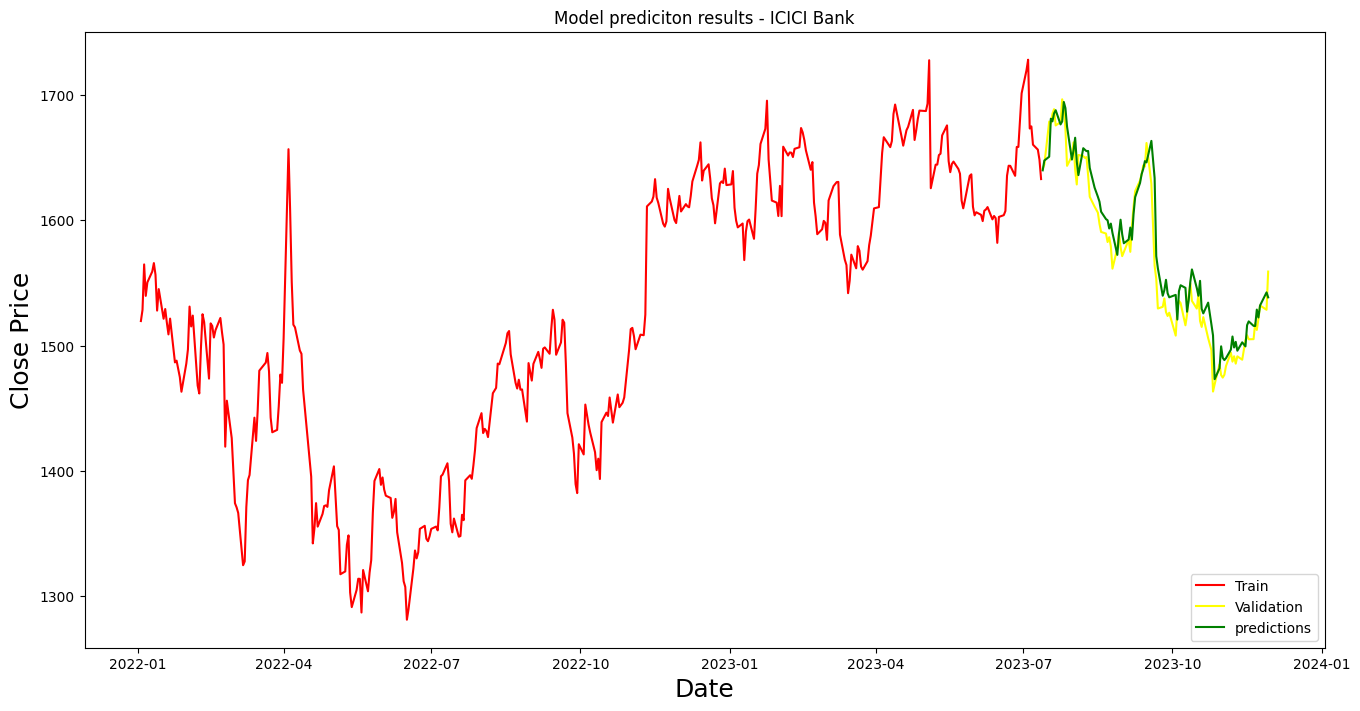

In [45]:
#plot the data
train=data[:training_data_len]
valid=data[training_data_len:]
valid['predictions'] = predictions

#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model prediciton results - ICICI Bank')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close'] , color='red')
plt.plot(valid['Close'] , color='yellow')
plt.plot(valid[ 'predictions'] , color='green')
plt.legend(['Train','Validation', 'predictions'], loc='lower right')
plt.show()

In [46]:
#Show the valid and predicted prices

valid.tail(20)

,Close,predictions
Date,,
2023-10-31,1476.500000,1499.479126
2023-11-01,1474.500000,1490.271240
2023-11-02,1476.750000,1488.509644
2023-11-03,1483.750000,1490.042847
2023-11-06,1494.500000,1496.837402
2023-11-07,1487.250000,1507.313965
2023-11-08,1491.550049,1498.536865
2023-11-09,1485.650024,1503.057373
2023-11-10,1491.500000,1495.980347


<h1><b>Getting Predictions for Tomorrow<b></h1>

In [47]:
#Get the quote
ticker = 'HDFCBANK.NS'
start_date = '2022-01-01'
end_date = '2023-11-30'
stock_quote = yf.download(ticker, start=start_date, end=end_date)

new_df=stock_quote.filter(['Close'])
#Get last 60 days values and convert into array
last_60_days=new_df[-60:].values

#Scale the data to be values between 0
last_60_days_scaled=scaler.transform(last_60_days)

#Create an empty list
X_test=[]
#Appemd the past 60days
X_test.append(last_60_days_scaled)

#Conver the X_test data into numpy array
X_test = np.array(X_test)

#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
#Get predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling
pred_price=scaler.inverse_transform(pred_price)
print(f'Price of {ticker} tomorrow:{pred_price}')

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 26ms/step
Price of HDFCBANK.NS tomorrow:[[1569.6118]]


<h1><b>Getting Predictions for 60 days from now<b></h1>

In [48]:
import yfinance as yf
import numpy as np

# Assuming you have the necessary imports and the 'model' and 'scaler' objects are defined

# Get the historical stock data
ticker = 'HDFCBANK.NS'
start_date = '2022-01-01'
end_date = '2023-11-30'
stock_quote = yf.download(ticker, start=start_date, end=end_date)

# Extract 'Close' prices
new_df = stock_quote.filter(['Close'])

# Take the last 60 days of 'Close' prices and scale them
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)

# Create an empty list to store predicted prices
predicted_prices = []

# Number of days to forecast (adjust as needed)
forecast_days = 60

# Loop through the forecast period
for _ in range(forecast_days):
    # Reshape the data for prediction
    X_test = np.array([last_60_days_scaled])
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Get predicted scaled price
    pred_price = model.predict(X_test)

    # Undo the scaling
    pred_price = scaler.inverse_transform(pred_price)

    # Append the predicted price to the list
    predicted_prices.append(pred_price[0, 0])

    # Update last_60_days for the next iteration
    last_60_days = np.append(last_60_days[1:], [pred_price[0]], axis=0)
    last_60_days_scaled = scaler.transform(last_60_days)

# Print the predicted prices for the next 60 days
for i, price in enumerate(predicted_prices, 1):
    print(f'Day {i}: Predicted Closing Price of {ticker}: {price}')


[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 25ms/step
Day 1: Predicted Closing Price of HDFCBANK.NS: 1569.61181640625
Day 2: Predicted Closing Price of HDFCBANK.NS: 1578.0797119140625
Day 3: Predicted Closing Price of HDFCBANK.NS: 1586.18359375
Day 4: Predicted Closing Price of HDFCBANK.NS: 1593.30078125
Day 5: Predicted Closing Price of HDFCBANK.NS: 1599.7547607421875
Day 6: Predicted Closing Price of HDFCBANK.NS: 1605.804931640625
Day 7: Predicted Closing Price of HDFCBANK.NS: 1611.6083984375
Day 8: Predicted Closing Price of HDFCBANK.NS: 1617.22998046875
Day 9: Predicted Closing Price of HDFCBANK.NS: 1622.6712646484375
Day 10: Predicted Closing Price of HDFCBANK.NS: 1627.9017333984375
Day 11: Predicted Closing Price of HDFCBANK.NS: 1632.881591796875
Day 12: Predicted Closing Price of HDFCBANK.NS: 1637.577392578125
Day 13: Predicted Closing Price of HDFCBANK.NS: 1641.96826171875
Day 14: Predicted Closing Price of HDFC